In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

## Dataset Instructions:

- You need to download the dataset from here: https://ai.stanford.edu/~amaas/data/sentiment/
- Then, you need to unzip the downloaded zipped file in the present working directory
- That should result in a new folder named aclImdb under the present working directory

In [11]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|█████████████████████████████████| 12500/12500 [00:00<00:00, 100162.77it/s]

Number of reviews : 25000


In [12]:
# pre-processing review text
# to lower
review_list = [review.lower() for review in review_list] 
# remove punctuation
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)] 

# accumulate all review texts together.
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews. create list separated by ",".
# ref(https://note.nkmk.me/python-split-rsplit-splitlines-re/)
review_words = reviews_blob.split()

# get the word counts
# cretate map like; [('a', 5), ('b', 2), ('r', 2)]
# [ref](https://docs.python.org/3/library/collections.html#collections.Counter)
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████████████████████████████| 25000/25000 [00:00<00:00, 28373.41it/s]

[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [13]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)} # throw away count.
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [14]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

this was one of the dvds i recently bought in a set of six called frenchfilm to brush up our french before our planned holiday in beautiful provence this year so far as well as improving our french we have considerably enhanced our appreciation of french cinemabr br what a breath of fresh air to the stale predictable unimaginative crash bang wallop drivel being churned out by hollywood what a good example for screenplay writers actors directors and cinematographers to follow it was so stimulating also to see two identifiable characters in the lead roles without them having to be glossy magazine cover figures br br the other thing i liked about this film was the slow character and plot build up which kept you guessing as to how it was all going to end is there any real good in this selfish thug who continually treats his seemingly naïve benefactor with the type of contempt that an excon would display will our sexually frustrated poor little half deaf heroine prove herself to the answer 

In [15]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

# length of each reviews 
reviews_len = [len(review) for review in reviews_tokenized]

# delete empty reviews
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]

# let encoded label list to numpy array. 
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

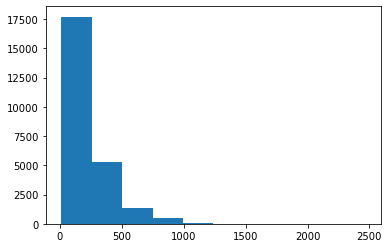

In [16]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    # create initial all 0 reviews
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review # add 0s to a head.
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length] # cut.
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

In [17]:
# split data into train and validation.
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [18]:
## If while training, you get a runtime error that says: "RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long".
## simply uncomment run the following lines of code additionally
# train_X = train_X.astype('int64')
# train_y = train_y.astype('int64')
# validation_X = validation_X.astype('int64')
# validation_y = validation_y.astype('int64')

In [19]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [20]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,   293,   781,   252],
        [    0,     0,     0,  ...,   103,    10,   585],
        [    0,     0,     0,  ...,     7,    55,  2258],
        ...,
        [    0,     0,     0,  ...,    45,     4,   301],
        [    0,     0,     0,  ...,     3,   124,   688],
        [    0,     0,     0,  ..., 60696,    12,  1947]], device='cuda:0')

Example Output size:  torch.Size([32])
Example Output:
 tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       device='cuda:0')


In [21]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension] (1 for normal RNN, 2 for bidirectional RNN.)
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0)) # squeeze first(0) dim=uni directional. ref: https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch.squeeze
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding 0. vocab_to_token = [('the', 1), ('and', 2),...]
embedding_dimension = 100 # embed feature dim.
hidden_dimension = 32
output_dimension = 1 # positive or negative.

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [22]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [23]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader: # sentiment means ground truth sentiment.
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment) # loss_func = nn.BCEWithLogitsLoss()
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [24]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)
            
            # no backward.() and optim.step().

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [25]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 7.949818134307861s
training loss: 0.622 | training accuracy: 66.34%
validation loss: 1.056 |  validation accuracy: 21.50%

epoch number: 2 | time elapsed: 7.81295108795166s
training loss: 0.523 | training accuracy: 74.29%
validation loss: 0.999 |  validation accuracy: 38.99%

epoch number: 3 | time elapsed: 7.674136638641357s
training loss: 0.437 | training accuracy: 80.13%
validation loss: 0.769 |  validation accuracy: 60.47%

epoch number: 4 | time elapsed: 7.675785064697266s
training loss: 0.360 | training accuracy: 84.67%
validation loss: 0.963 |  validation accuracy: 56.90%

epoch number: 5 | time elapsed: 7.681114196777344s
training loss: 0.284 | training accuracy: 88.86%
validation loss: 0.686 |  validation accuracy: 72.81%

epoch number: 6 | time elapsed: 7.688571214675903s
training loss: 0.224 | training accuracy: 91.62%
validation loss: 0.924 |  validation accuracy: 64.83%

epoch number: 7 | time elapsed: 7.689738988876343s
training loss: 0.270

In [26]:
def sentiment_inference(model, sentence):
    model.eval() # set the model as evaluation mode.
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    # pad with constant value;0. ref: https://numpy.org/doc/stable/reference/generated/numpy.pad.html
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device) # 64-bit integer (signed). ref; https://pytorch.org/docs/stable/tensors.html
    model_input = model_input.unsqueeze(1) # add batch size 1. ref: https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [27]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.02654528245329857
0.535542368888855
0.9582849740982056
0.9869621992111206
0.993883490562439
